# Pylops - Sparse solvers with cupy

In [1]:
# install conda (https://towardsdatascience.com/conda-google-colab-75f7c867a522)
%env PYTHONPATH=

env: PYTHONPATH=


In [2]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2020-10-31 16:18:36--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-10-31 16:18:36--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 1.31M 43s
    50K .......... .......... .......... .......... ..........  0

In [3]:
%%bash
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pycparser-2.20             |             py_2          94 KB
    requests-2.24.0            |             py_0          54 KB
    certifi-2020.6.20          |     pyhd3eb1b0_3         159 KB
    idna-2.10                  |             py_0          56 KB
    pycosat-0.6.3              |   py36h7b6447c_0         107 KB
    pysocks-1.7.1              |           py36_0          30 KB
    brotlipy-0.7.0             |py36h7b6447c_1000         348 KB
    conda-4.9.1                |   py36h06a4308_0         3.1 MB
    openssl-1.1.1h             |       h7b6447c_0         3.8 MB
    urllib3-1.25.11            |             py_0          93 KB
    ruamel_yaml-0.15.87        |   py36h7b6447c_1   

pycparser-2.20       |   94 KB | ########## | 100% 
requests-2.24.0      |   54 KB | ########## | 100% 
certifi-2020.6.20    |  159 KB | ########## | 100% 
idna-2.10            |   56 KB | ########## | 100% 
pycosat-0.6.3        |  107 KB | ########## | 100% 
pysocks-1.7.1        |   30 KB | ########## | 100% 
brotlipy-0.7.0       |  348 KB | ########## | 100% 
conda-4.9.1          |  3.1 MB | ########## | 100% 
openssl-1.1.1h       |  3.8 MB | ########## | 100% 
urllib3-1.25.11      |   93 KB | ########## | 100% 
ruamel_yaml-0.15.87  |  256 KB | ########## | 100% 
ld_impl_linux-64-2.3 |  645 KB | ########## | 100% 
pip-20.2.4           |  2.0 MB | ########## | 100% 
python-3.6.12        | 34.0 MB | ########## | 100% 
cffi-1.14.3          |  224 KB | ########## | 100% 
libffi-3.3           |   54 KB | ########## | 100% 
ca-certificates-2020 |  128 KB | ########## | 100% 
libedit-3.1.20191231 |  121 KB | ########## | 100% 
_libgcc_mutex-0.1    |    3 KB | ########## | 100% 
tk-8.6.10   

In [4]:
!python --version # now returns Python 3.6.10 :: Anaconda, Inc.

Python 3.6.12 :: Anaconda, Inc.


In [5]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

In [6]:
!conda install -c rapidsai -c conda-forge cusignal cudatoolkit=10.1 --yes

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=10.1
    - cusignal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py36h79e6602_1         312 KB  conda-forge
    boost-cpp-1.74.0           |       h9359b55_0        16.4 MB  conda-forge
    bzip2-1.0.8                |       h516909a_3         398 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    cudatoolkit-10.1.243       |       h6bb024c_0       347.4 MB
    cudnn-7.6.5                |       cuda10.1_0       179.9 MB
    cupy-8.1.0                 |   py36h1175eb7_0        34.1 MB  conda-

In [7]:
#!pip install cupy-cuda101
!pip3 install cupy-cuda101==8.0.0rc1 --upgrade
#!pip install pylops[advanced]
!pip3 install git+https://github.com/mrava87/pylops@cupy-ext

     |████████████████████████████████| 114.9 MB 14 kB/s 
  Cloning https://github.com/mrava87/pylops (to revision cupy-ext) to /tmp/pip-req-build-y56_gvje
  Created wheel for pylops: filename=pylops-1.10.1.dev100+gdb24361-py3-none-any.whl size=163449 sha256=beece8357816b8b10702cc1b54a6a0eaf23c15c88aad55b9561d2ddeed4c06e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-dynny6ya/wheels/92/3f/33/bb1bd7335dab4f72f8e54c5c935b290d143c80c09cb50b8b28
Successfully built pylops


In [8]:
# all RAPIDS env... : https://medium.com/dropout-analytics/installing-rapids-ai-in-google-colab-87c247f2c468
# https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=CtNdk7PSafKP

In [9]:
!rm -rf /usr/local/lib/python3.6/dist-packages/cupy*

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from google.colab import drive
from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.sparsity import *

np.random.seed(10)

## MP, OMP, STA , FISTA

In [11]:
N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
A = cp.array(A)
Aop = MatrixMult(A)

#x = np.random.rand(M)
x = cp.random.rand(M)
x[x < 0.9] = 0
y = Aop*x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performanc

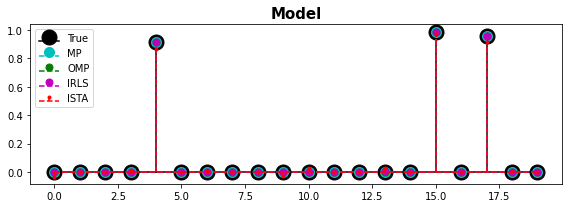

In [12]:
# MP/OMP
eps = 1e-2
maxit = 500
x_mp = OMP(Aop, y, maxit, niter_inner=0, sigma=1e-4)[0]
x_omp = OMP(Aop, y, maxit, sigma=1e-4)[0]

# IRLS
x_irls = IRLS(Aop, y, 50, epsI=1e-5, kind='model', **dict(niter=10))[0]

# ISTA
x_ista = ISTA(Aop, y, maxit, eps=eps, alpha=2.569474e-01, tol=1e-3, show=False)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
m, s, b = ax.stem(cp.asnumpy(x), linefmt='k', basefmt='k',
                  markerfmt='ko', label='True')
plt.setp(m, markersize = 15)
m, s, b = ax.stem(cp.asnumpy(x_mp), linefmt='--c', basefmt='--c',
        markerfmt='co', label='MP')
plt.setp(m, markersize = 10)
m, s, b = ax.stem(cp.asnumpy(x_omp), linefmt='--g', basefmt='--g',
        markerfmt='go', label='OMP')
plt.setp(m, markersize = 7)
m, s, b = ax.stem(cp.asnumpy(x_irls), linefmt='--m', basefmt='--m',
                  markerfmt='mo', label='IRLS')
plt.setp(m, markersize=7)
m, s, b = ax.stem(cp.asnumpy(x_ista), linefmt='--r', basefmt='--r',
                  markerfmt='ro', label='ISTA')
plt.setp(m, markersize = 3)
ax.set_title('Model', size=15, fontweight='bold')
ax.legend()
plt.tight_layout()

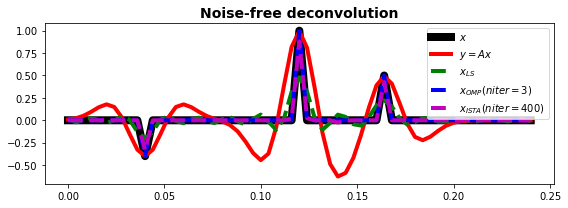

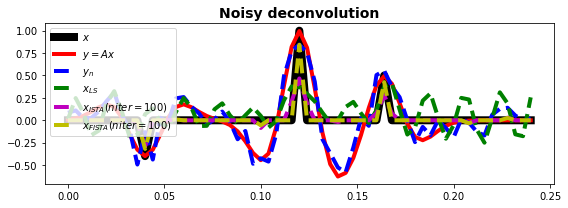

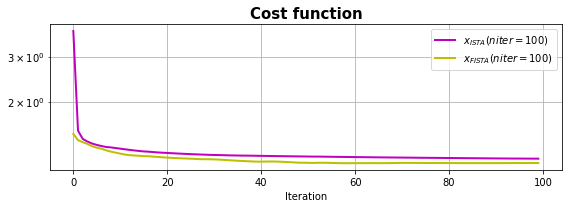

In [13]:
nt = 61
dt = 0.004
t = np.arange(nt)*dt
x = np.zeros(nt, dtype='float32')
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5

h, th, hcenter = ricker(t[:101], f0=20)

Cop = Convolve1D(nt, h=h.astype('float32'), offset=hcenter, dtype='float32')
y = Cop*x
yn = y + np.random.normal(0, 0.1, y.shape).astype('float32')

# noise free
xls = Cop / y

xomp, nitero, costo = OMP(Cop, y, niter_outer=200, sigma=1e-8)

xista, niteri, costi = ISTA(Cop, y, niter=400, eps=5e-1,
                            tol=1e-8, returninfo=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x, 'k', lw=8, label=r'$x$')
ax.plot(t, y, 'r', lw=4, label=r'$y=Ax$')
ax.plot(t, xls, '--g', lw=4, label=r'$x_{LS}$')
ax.plot(t, xomp, '--b', lw=4, label=r'$x_{OMP} (niter=%d)$' % nitero)
ax.plot(t, xista, '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)

ax.set_title('Noise-free deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

# noisy
xls = RegularizedInversion(Cop, [], yn,
                           returninfo=False,
                           **dict(damp=1e-1,
                                  atol=1e-3,
                                  iter_lim=100,
                                  show=0))

xista, niteri, costi = ISTA(Cop, yn, niter=100, eps=5e-1,
                            tol=1e-5, returninfo=True)

xfista, niterf, costf = FISTA(Cop, yn, niter=100, eps=5e-1,
                              tol=1e-5, returninfo=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x, 'k', lw=8, label=r'$x$')
ax.plot(t, y, 'r', lw=4, label=r'$y=Ax$')
ax.plot(t, yn, '--b', lw=4, label=r'$y_n$')
ax.plot(t, xls, '--g', lw=4, label=r'$x_{LS}$')
ax.plot(t, xista, '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.plot(t, xfista, '--y', lw=4, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Noisy deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'm', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'y', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

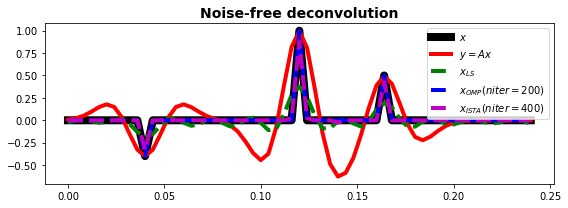

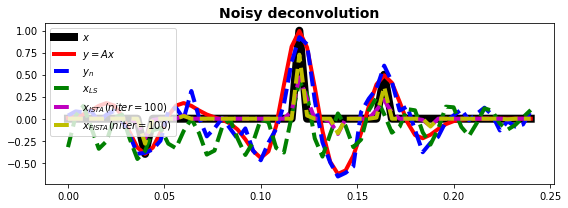

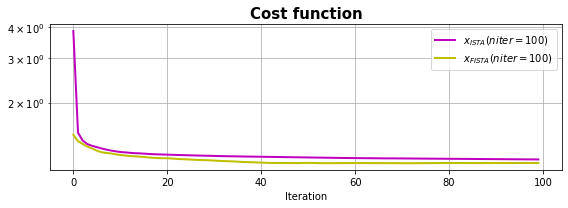

In [14]:
nt = 61
dt = 0.004
t = np.arange(nt)*dt
x = np.zeros(nt, dtype='float32')
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5
x = cp.array(x)

h, th, hcenter = ricker(t[:101], f0=20)

Cop = Convolve1D(nt, h=cp.array(h).astype('float32'), offset=hcenter, dtype='float32')
y = Cop*x
yn = y + cp.random.normal(0, 0.1, y.shape).astype('float32')

# noise free
xls = Cop / y

xomp, nitero, costo = OMP(Cop, y, niter_outer=200, sigma=1e-8)

xista, niteri, costi = ISTA(Cop, y, niter=400, alpha=3.842706e-2, eps=5e-1,
                            tol=1e-8, returninfo=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=8, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=4, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xls), '--g', lw=4, label=r'$x_{LS}$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xomp), '--b', lw=4, label=r'$x_{OMP} (niter=%d)$' % nitero)
ax.plot(cp.asnumpy(t), cp.asnumpy(xista), '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)

ax.set_title('Noise-free deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

# noisy
xls = RegularizedInversion(Cop, [], yn,
                           returninfo=False,
                           **dict(damp=1e-1,
                                  niter=100,
                                  show=0))

xista, niteri, costi = ISTA(Cop, yn, niter=100,alpha=3.842706e-2, eps=5e-1,
                            tol=1e-5, returninfo=True)

xfista, niterf, costf = FISTA(Cop, yn, niter=100, alpha=3.842706e-2, eps=5e-1,
                              tol=1e-5, returninfo=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=8, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=4, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(yn), '--b', lw=4, label=r'$y_n$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xls), '--g', lw=4, label=r'$x_{LS}$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xista), '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.plot(cp.asnumpy(t), cp.asnumpy(xfista), '--y', lw=4, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Noisy deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'm', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'y', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

## Split-Bregman

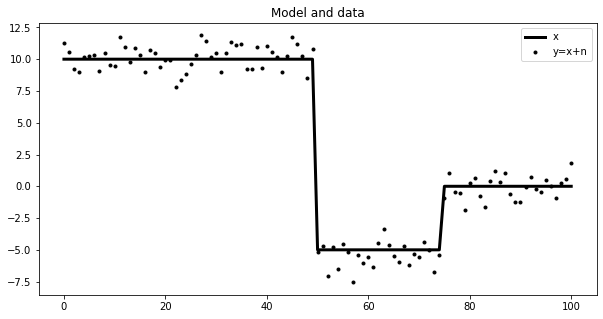

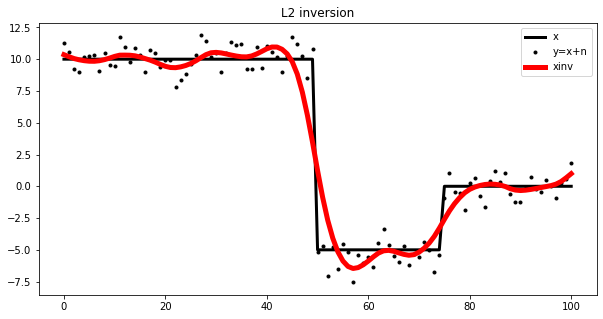

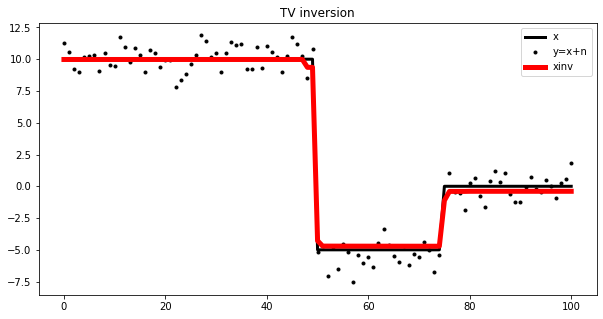

In [15]:
np.random.seed(1)

nx = 101
x = cp.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5

Iop = Identity(nx)

n = cp.random.normal(0, 1, nx)
y = Iop*(x + n)

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.legend()
plt.title('Model and data')

D2op = SecondDerivative(nx, edge=True)
lamda = 1e2

xinv = RegularizedInversion(Iop, [D2op], y, epsRs=[np.sqrt(lamda/2)],
                            **dict(niter=30))

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.plot(cp.asnumpy(xinv), 'r', lw=5, label='xinv')
plt.legend()
plt.title('L2 inversion')

Dop = FirstDerivative(nx, edge=True, kind='backward')
mu = 0.01
lamda = 0.3
niter_out = 50
niter_in = 3

xinv, niter = \
    SplitBregman(Iop, [Dop], y, niter_out,
                 niter_in, mu=mu, epsRL1s=[lamda],
                 tol=1e-4, tau=1.,
                 **dict(niter=30, damp=1e-10))

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.plot(cp.asnumpy(xinv), 'r', lw=5, label='xinv')
plt.legend()
plt.title('TV inversion');

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 24000 rows and 40000 cols
niter_outer =  20     niter_inner =  10   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [0.1, 0.1]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -2.83526e-02        2.754e-01        1.992e+03
     2   3.18473e-03        2.650e-01        1.441e+03
     3   3.40626e-02        2.413e-01        1.382e+03
     4   6.00978e-02        2.165e-01        1.347e+03
     5   7.51758e-02        1.970e-01        1.326e+03
     6   7.99494e-02        1.816e-01        1.324e+03
     7   7.54115e-02        1.724e-01        1.329e+03
     8   7.52080e-02        1.647e-01        1.318e+03
     9   7.51747e-02        1.597e-01        1.317e+03
    10   4.28902e-02        1.512e-01        1.295e+03
    11   1.46775e-02        1.449e-01        1.289e+03
    12  -1.51159e-02        1.39

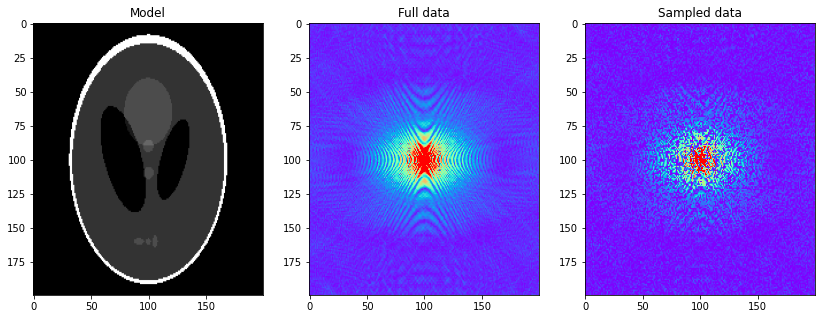

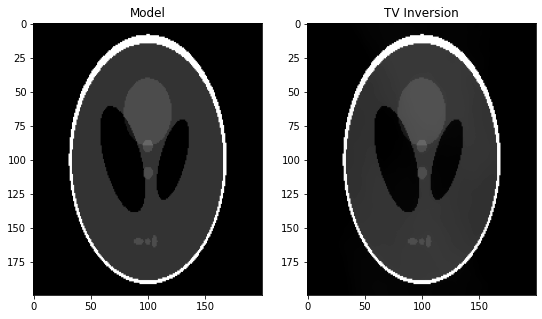

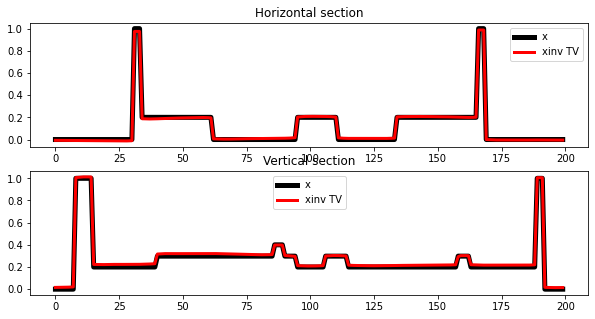

In [16]:
from skimage.data import shepp_logan_phantom

x = cp.array(shepp_logan_phantom()[::2, ::2])
x = x/x.max()
ny, nx = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = Restriction(ny*nx, iava, dtype=np.complex)
Fop = FFT2D(dims=(ny, nx))

n = cp.random.normal(0, 0., (ny, nx))
y = Rop*Fop*(x.flatten() + n.flatten())
yfft = Fop*(x.flatten() + n.flatten())
yfft = cp.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(cp.asnumpy(x), vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(np.abs(yfft)), vmin=0, vmax=1, cmap='rainbow')
axs[1].set_title('Full data')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(np.abs(ymask)), vmin=0, vmax=1, cmap='rainbow')
axs[2].set_title('Sampled data')
axs[2].axis('tight')

Dop = \
    [FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                            kind='backward', dtype=np.complex),
     FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                            kind='backward', dtype=np.complex)]

# TV
mu = 1.5
lamda = [0.1, 0.1]
niter = 20
niterinner = 10

xinv, niter = \
    SplitBregman(Rop * Fop, Dop, y.flatten(),
                 niter, niterinner,
                 mu=mu, epsRL1s=lamda,
                 tol=1e-4, tau=1., show=True,
                 **dict(niter=5, damp=1e-8))
xinv = cp.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(cp.asnumpy(x), vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(xinv), vmin=0, vmax=1, cmap='gray')
axs[1].set_title('TV Inversion')
axs[1].axis('tight')

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(cp.asnumpy(x[ny//2]), 'k', lw=5, label='x')
axs[0].plot(cp.asnumpy(xinv[ny//2]), 'r', lw=3, label='xinv TV')
axs[0].set_title('Horizontal section')
axs[0].legend()
axs[1].plot(cp.asnumpy(x[:, nx//2]), 'k', lw=5, label='x')
axs[1].plot(cp.asnumpy(xinv[:, nx//2]), 'r', lw=3, label='xinv TV')
axs[1].set_title('Vertical section')
axs[1].legend()